## Preparation

Login to your Hugging Face account (create one [here](https://hf.co/join) if you don't already have one!). You can login from a notebook and enter your token when prompted:

In [1]:
# from huggingface_hub import notebook_login

# notebook_login()

Or login in from the terminal:

```bash
huggingface-cli login
```

Since the model checkpoints are quite large, install [Git-LFS](https://git-lfs.com/) to version these large files:

```bash
!sudo apt -qq install git-lfs
!git config --global credential.helper store
```

Create repo if not exist, trained model will be pushed to Hugging Face Model Hub.

In [2]:
# from huggingface_hub import create_repo

# create_repo("HoarfrostRaven/ddpm-fibres-256")

Create dataset if not exist.

In [3]:
# from datasets import load_dataset

# dataset = load_dataset("imagefolder", data_dir="C:\\Applications\\Projets\\FibreAug\\dataset\\raw_data\\images")
# dataset.push_to_hub("HoarfrostRaven/fibers")

## Training configuration

For convenience, create a `TrainingConfig` class containing the training hyperparameters :

In [4]:
from dataclasses import dataclass
import torch


@dataclass
class TrainingConfig:
    image_size = [128, 128]  # Dimensions must be a multiple of `2 ** (len(block_out_channels) - 1)`
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 200
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 5
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-fibres-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load the dataset

In [5]:
from datasets import load_dataset

config.dataset_name = "HoarfrostRaven/fibres_128"
dataset = load_dataset(config.dataset_name, split="train")

Visualize the dataset:

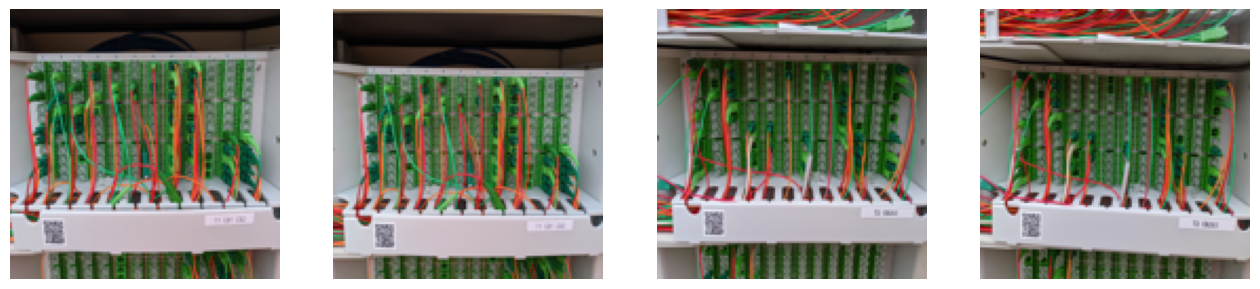

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

Preprocess the images:

* `Resize` changes the image size to the one defined in `config.image_size`.
* `RandomHorizontalFlip` augments the dataset by randomly mirroring the images.
* `Normalize` is important to rescale the pixel values into a [-1, 1] range, which is what the model expects.

In [7]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        # transforms.Resize(config.image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Use [set_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.set_transform) method to apply the `preprocess` function on images during training:

In [8]:
from PIL import Image

def transform(examples):
    images = [preprocess(Image.fromarray(np.array(image, dtype=np.uint8), 'RGB')) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

Revisualize the dataset:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


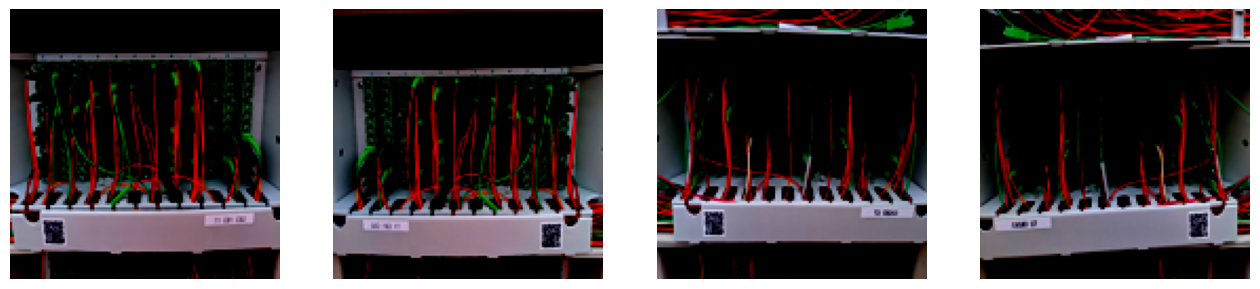

In [9]:
import numpy as np

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    image = np.transpose(image, (1, 2, 0))
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

Wrap the dataset in a [DataLoader](https://pytorch.org/docs/stable/data#torch.utils.data.DataLoader) for training:

In [10]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

## Create a UNet2DModel

Create a [UNet2DModel](https://huggingface.co/docs/diffusers/main/en/api/models#diffusers.UNet2DModel):

In [11]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels, 3 for RGB images
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256),  # the number of output channels for each UNet block
    down_block_types=(
        # "DownBlock2D",  # a regular ResNet downsampling block
        # "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        # "UpBlock2D",
        # "UpBlock2D",
    ),
)

# model = UNet2DModel.from_pretrained("HoarfrostRaven/ddpm-sprites-16")

Check the sample image shape matches the model output shape:

In [12]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


### Collect modules to apply PEFT:

In [13]:
# import torch.nn as nn
# target_modules = []
# target_modules = [
#     name
#     for name, module in model.named_modules()
#     if isinstance(module, (nn.Linear, nn.Conv2d, nn.Embedding, nn.ConvTranspose2d))
# ]

Apply PEFT:

In [14]:
# from peft import LoraConfig, get_peft_model

# peft_config = LoraConfig(target_modules=target_modules, # (`Union[List[str],str]`): The names of the modules to apply Lora to.
#                          inference_mode=False, # False for train, True for inference
#                          r=16, # (`int`): Lora attention dimension.
#                          lora_alpha=16, # The alpha parameter for Lora scaling.
#                          lora_dropout=0.1, # The dropout probability for Lora layers.
#                          bias="all" # (`str`): Bias type for Lora. Can be 'none', 'all' or 'lora_only'
# )
# model = get_peft_model(model, peft_config)
# model.print_trainable_parameters()

In [15]:
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0

## Create a scheduler

The scheduler behaves differently depending on whether you're using the model for training or inference. During inference, the scheduler generates image from the noise. During training, the scheduler takes a model output - or a sample - from a specific point in the diffusion process and applies noise to the image according to a *noise schedule* and an *update rule*.

Let's take a look at the [DDPMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/ddpm#diffusers.DDPMScheduler) and use the `add_noise` method to add some random noise to the `sample_image` from before:

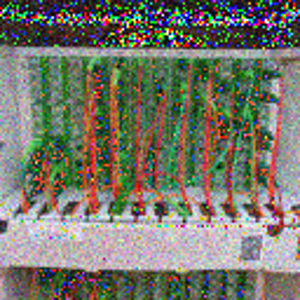

In [16]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

# Convert the noisy image tensor to a PIL Image object for visualization
# Rearrange the dimensions of the tensor to match the expected image format
# Scale the pixel values from the range [-1, 1] to [0, 255] and convert to uint8 type
# Extract the first image from the batch and convert it to a numpy array
# Create a PIL Image object from the numpy array and display it
image_to_show = ((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0]

# Create a PIL Image object from the numpy array
pil_image = Image.fromarray(image_to_show)

# Resize the image to make it larger (e.g., 200x200)
# Change the 'new_size' tuple to the desired size
new_size = (300, 300)
resized_image = pil_image.resize(new_size)

# Display the resized image
resized_image.show()

The training objective of the model is to predict the noise added to the image. The loss at this step can be calculated by:

In [17]:
import torch.nn.functional as F

noise_pred = model(noisy_image.to(device), timesteps.to(device)).sample
loss = F.mse_loss(noise_pred, noise.to(device))

## Train the model

Construct an optimizer and a learning rate scheduler:

In [18]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

Then, you'll need a way to evaluate the model. For evaluation, you can use the [DDPMPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/ddpm#diffusers.DDPMPipeline) to generate a batch of sample images and save it as a grid:

In [19]:
from diffusers import DDPMPipeline
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

To upload the model to the Hub, write a function to get your repository name and information and then push it to the Hub.

In [20]:
from huggingface_hub import HfFolder, whoami

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is not None:
        return f"{organization}/{model_id}"
    username = whoami(token)["name"]
    return f"{username}/{model_id}"

In [21]:
from accelerate import Accelerator
from huggingface_hub import Repository
from tqdm.auto import tqdm
from pathlib import Path
import os


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    # Register the LR scheduler
    accelerator.register_for_checkpointing(lr_scheduler)

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

Launch the training with Accelerate's [notebook_launcher](https://huggingface.co/docs/accelerate/main/en/package_reference/launchers#accelerate.notebook_launcher) function. Pass the function the training loop, all the training arguments, and the number of processes (you can change this value to the number of GPUs available to you) to use for training:

In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


/usr/local/lib/python3.9/dist-packages/accelerate/accelerator.py:371: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
/home/FibreAug/code/ddpm-fibres-128 is already a clone of https://huggingface.co/HoarfrostRaven/ddpm-fibres-128. Make sure you pull the latest changes with `repo.git_pull()`.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0004.png']. This may take a bit of time if the files are large.


Upload file samples/0004.png:   1%|          | 3.30k/604k [00:00<?, ?B/s]

To https://huggingface.co/HoarfrostRaven/ddpm-fibres-128
   75c6a17..ccf8ff0  main -> main



  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/.ipynb_checkpoints/0000-checkpoint.png', 'samples/.ipynb_checkpoints/0004-checkpoint.png', 'samples/0009.png']. This may take a bit of time if the files are large.


Upload file samples/0009.png:   1%|          | 3.30k/566k [00:00<?, ?B/s]

To https://huggingface.co/HoarfrostRaven/ddpm-fibres-128
   ccf8ff0..01ec9b9  main -> main



  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0014.png']. This may take a bit of time if the files are large.


Upload file samples/0014.png:   1%|          | 3.30k/545k [00:00<?, ?B/s]

To https://huggingface.co/HoarfrostRaven/ddpm-fibres-128
   01ec9b9..e56cb6d  main -> main



  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0019.png']. This may take a bit of time if the files are large.


Upload file samples/0019.png:   1%|          | 3.30k/542k [00:00<?, ?B/s]

To https://huggingface.co/HoarfrostRaven/ddpm-fibres-128
   e56cb6d..a96ab83  main -> main



  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0024.png']. This may take a bit of time if the files are large.


Upload file samples/0024.png:   1%|          | 3.30k/539k [00:00<?, ?B/s]

To https://huggingface.co/HoarfrostRaven/ddpm-fibres-128
   a96ab83..88ae098  main -> main



  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0029.png']. This may take a bit of time if the files are large.


Upload file samples/0029.png:   1%|          | 3.30k/527k [00:00<?, ?B/s]

To https://huggingface.co/HoarfrostRaven/ddpm-fibres-128
   88ae098..bf9f56d  main -> main



  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Once training is complete, take a look at the final images generated by diffusion model:

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))

In [ ]:
# Open the image using PIL
pil_image = Image.open(sample_images[-1])

# Resize the image to make it larger (e.g., 200x200)
# Change the 'new_size' tuple to the desired size
new_size = (500, 500)
resized_image = pil_image.resize(new_size)

# Display the resized image
resized_image.show()